In [1]:
# import 

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

# colors
import matplotlib.colors as mcolors
from matplotlib import cm
# set style
import seaborn as sns

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [2]:
from rdflib import Graph

f = Graph() #/u/98/peurat1/unix/Desktop/kirjasampo/data/graph2.ttl
#f.parse(data="../../data/finnish_graph2.nt", format="nt")

f.parse('../../data/finnish_graph_new.nt')

# foreign
g = Graph() #/u/98/peurat1/unix/Desktop/kirjasampo/data/graph2.ttl
#f.parse(data="../../data/finnish_graph2.nt", format="nt")

g.parse('../../data/nat_lang_graph2.nt')

<Graph identifier=Neb2e96ba76914952bb618d7e3785f59f (<class 'rdflib.graph.Graph'>)>

In [3]:
# genre

genre=pd.read_csv("../../data/genre_df.csv", sep="\t", index_col=0)
genre_dict={}
for i,v in genre.groupby("genrename").apply(lambda x: list(x["genre"])).iteritems():
   # print(i,v)
    #genre_dict[i]=" ".join(["<"+uri+">" for uri in v])
    genre_dict[i] =v

    
# cluster per genre information
# load genre graphs
g_fi = Graph() 
g_fi.parse("../../data/finnish_genre_theme.nt",format="nt")

g_fo = Graph() 
g_fo.parse("../data/translated_theme_genre_new.nt",format="nt")

<Graph identifier=N89b78aac45e74fe2a591bf9d7eb2adb2 (<class 'rdflib.graph.Graph'>)>

In [4]:
# add broader category 

from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')

# add the broader genre to these
g2=g_fi
check_q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT ?broader (COUNT(DISTINCT ?teos) AS ?novels) WHERE 
    { ?genre rel:broaderCategory <CAT> .  ?teos rel:hasGenre ?genre . BIND (<CAT> as ?broader ) }
    GROUP BY ?broader

    """

allres={key:[] for key in genre_dict.keys()}
for key,val in genre_dict.items():
    #if len(v)> 1:
    print(key)
    # insert broader
    
    
    g2.add((URIRef(key), RDF.type, rel.broaderCategory))
    
    
    for v in val:
        g2.add((URIRef(v),  rel.broaderCategory, URIRef(key)))
            
    
    c_q=check_q.replace("CAT", key)
    qres = g2.query(c_q)
    allres[key] += qres
    
    
category="lapset"
print("Found", allres[category], "novels of category", category)

elain
era
erotiikka
fantasia
historia
huumori
jannitys
kauhu
lapset
nuoret
rakkaus
scifi
sota
urheilu
uskonto
Found [(rdflib.term.URIRef('lapset'), rdflib.term.Literal('986', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))] novels of category lapset


In [5]:
# add broader category to foreign

from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')

# add the broader genre to these
g_fo2=g_fo
check_q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT ?broader (COUNT(DISTINCT ?teos) AS ?novels) WHERE 
    { ?genre rel:broaderCategory <CAT> .  ?teos rel:hasGenre ?genre . BIND (<CAT> as ?broader ) }
    GROUP BY ?broader

    """

allres={key:[] for key in genre_dict.keys()}
for key,val in genre_dict.items():
    #if len(v)> 1:
    print(key)
    # insert broader
    
    
    g_fo2.add((URIRef(key), RDF.type, rel.broaderCategory))
    
    
    for v in val:
        g_fo2.add((URIRef(v),  rel.broaderCategory, URIRef(key)))
            
    
    c_q=check_q.replace("CAT", key)
    qres = g_fo2.query(c_q)
    allres[key] += qres

category="lapset"
print("Found", allres[category], "novels of category", category)

elain
era
erotiikka
fantasia
historia
huumori
jannitys
kauhu
lapset
nuoret
rakkaus
scifi
sota
urheilu
uskonto
Found [(rdflib.term.URIRef('lapset'), rdflib.term.Literal('960', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))] novels of category lapset


In [6]:
## viihde: select rakkaus, jannitys ja huumori

# hae kaikki teokset

Q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?broader ?teos ?year ?lang  ?author WHERE 
    { ?genre rel:broaderCategory <CAT> .  
        ?teos rel:hasGenre ?genre . 
        BIND (<CAT> as ?broader ) 
        ?teos rel:pubYear ?year .
        ?teos rel:hasAuthor ?author.
       #?author foaf:gender ?gender .
       # OPTIONAL {?author rel:authorNationality ?nat1 . }
        
        #BIND(COALESCE(?gender1, "unk") AS ?gender)
        ?teos rel:langOrig ?lang .
        
        }
    GROUP BY ?teos ?lang ?year ?broader  ?author

    """

viihde_genres=[]
for cat in ["rakkaus","jannitys","huumori"]:
    print(cat)
    q= Q.replace("CAT",cat)
    qres = g_fo2.query(q)
    genre =[{"genre":str(row.asdict()['broader'].toPython()),"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython()),"lang":str(row.asdict()['lang'].toPython()),"author":str(row.asdict()['author'].toPython())}  for row in qres]
    viihde_genres.append(genre)

rakkaus
jannitys
huumori


In [7]:
## viihde: select rakkaus, jannitys ja huumori

# Finnish
# hae kaikki teokset

Q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?broader ?teos ?year   WHERE 
    { ?genre rel:broaderCategory <CAT> .  
        ?teos rel:hasGenre ?genre . 
        BIND (<CAT> as ?broader ) 
        ?teos rel:pubYear ?year .
       # ?teos rel:hasAuthor ?author.
       #?author foaf:gender ?gender .
       # OPTIONAL {?author rel:authorNationality ?nat1 . }
        
        #BIND(COALESCE(?gender1, "unk") AS ?gender)
        #?teos rel:langOrig ?lang .
        
        }
    GROUP BY ?teos ?year ?broader # ?author

    """

viihde_genres_fi=[]
for cat in ["rakkaus","jannitys","huumori"]:
    print(cat)
    q= Q.replace("CAT",cat)
    qres = g2.query(q)
    genre =[{"genre":str(row.asdict()['broader'].toPython()),"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython())}  for row in qres]
    viihde_genres_fi.append(genre)

rakkaus
jannitys
huumori


In [8]:
# 5-year tuples

# tuples
end_year=2022
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]# five year periods
# make 5-year bins


# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

In [9]:
df_fo= pd.DataFrame()

for a in viihde_genres:
    df_fo= pd.concat([df_fo, pd.DataFrame(a)])

print(len(df_fo))
df_fo["year"]=pd.to_numeric(df_fo["year"])
df_fo["decade"]=(df_fo["year"]-1)- ((df_fo["year"]-1)%10)
df_fo.sort_values(by="year", inplace=True)
df_fo.head()

9379


,genre,year,novel,lang,author,decade
2300,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_7501,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970
1237,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_3931,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970
2418,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_4288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970
2424,jannitys,1971,http://seco.tkk.fi/saha3/u6774e1fb-9c17-40b8-b...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970
4723,jannitys,1971,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,1970


In [10]:
df_fi= pd.DataFrame()

for a in viihde_genres_fi:
    df_fi= pd.concat([df_fi, pd.DataFrame(a)])

print(len(df_fi))
df_fi["year"]=pd.to_numeric(df_fi["year"])
df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
df_fi.sort_values(by="year", inplace=True)
df_fi.head()

4687


,genre,year,novel,decade
1291,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_45406,1970
830,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_28462,1970
1679,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_40845,1970
255,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_49172,1970
2341,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_44793,1970


In [11]:
# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [12]:
df_fi=add_period(df_fi)

In [13]:
# add period
df_fo['period'] = pd.cut(df_fo['year'], bins=bins, include_lowest=True, precision=0)
df_fo['period'] = df_fo['period'].astype("str")

df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
df_fo.head()

,genre,year,novel,lang,author,decade,period
2300,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_7501,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971
1237,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_3931,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971
2418,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_4288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971
2424,jannitys,1971,http://seco.tkk.fi/saha3/u6774e1fb-9c17-40b8-b...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971
4723,jannitys,1971,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,1970,1971


In [14]:
# connect to author nationality and gender

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?author ?gender

{
  ?teos a rel:novel .
  
  ?teos rel:hasAuthor ?author .
 ?author foaf:gender ?gender .
 
  
} 

"""

qres = g.query(Q)

author_gender={str(row.asdict()['author'].toPython()):str(row.asdict()['gender'].toPython()) for row in qres}

In [15]:
# connect to author nationality and gender

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?author ?nat

{
  ?teos a rel:novel .
  
  ?teos rel:hasAuthor ?author .
 ?author rel:authorNationality ?nat .
 
  
} 

"""

qres = g.query(Q)

author_nationality={str(row.asdict()['author'].toPython()):str(row.asdict()['nat'].toPython()) for row in qres}

In [16]:
df_fo['nat'] = df_fo['author'].map(author_nationality)
df_fo['gender'] = df_fo['author'].map(author_gender)
print(len(df_fo))

print(df_fo.nat.isna().unique())
print(df_fo.isna().sum())
df_fo.head()

9379
[False  True]
genre       0
year        0
novel       0
lang        0
author      0
decade      0
period      0
nat       495
gender    277
dtype: int64


,genre,year,novel,lang,author,decade,period,nat,gender
2300,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_7501,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p3437,http://www.yso.fi/onto/kaunokki#male
1237,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_3931,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p3437,http://www.yso.fi/onto/kaunokki#female
2418,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_4288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female
2424,jannitys,1971,http://seco.tkk.fi/saha3/u6774e1fb-9c17-40b8-b...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male
4723,jannitys,1971,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,1970,1971,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male


In [17]:
# total number of books per year

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?teos ?author ?year ?gender

{
  ?teos a rel:novel .
  ?teos rel:hasAuthor ?author.
  OPTIONAL { ?author foaf:gender ?gender_ } 
  BIND(COALESCE(?gender_, "unk") AS ?gender)
  
  ?teos rel:pubYear ?year .
 FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} 

"""

qres = g.query(Q)
novels_per_year=[{"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython()),"author":str(row.asdict()['author'].toPython()),"gender":str(row.asdict()['gender'].toPython())}  for row in qres]


In [18]:
# total number of books per year
# fi
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?teos ?author ?year ?gender

{
  ?teos a rel:novel .
  ?teos rel:hasAuthor ?author.
  
  ?teos rel:pubYear ?year .
  OPTIONAL { ?author foaf:gender ?gender_ } 
  BIND(COALESCE(?gender_, "unk") AS ?gender)
 FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?teos ?author ?year ?gender

"""

qres = f.query(Q)
novels_per_year_fi=[{"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython()),"author":str(row.asdict()['author'].toPython()),"gender":str(row.asdict()['gender'].toPython())}  for row in qres]


In [19]:
novel_df=pd.DataFrame(novels_per_year)
novel_df["year"]=pd.to_numeric(novel_df["year"])
novel_df.head()

,year,novel,author,gender
0,2014,http://data.kirjasampo.fi/abstractWork_4075992,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#female
1,2013,http://www.btj.fi/at_1940412,http://seco.tkk.fi/saha3/u64eb3370-2fde-4c01-a...,http://www.yso.fi/onto/kaunokki#male
2,2004,http://www.yso.fi/onto/kaunokki#ateos_10798,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male
3,2000,http://www.yso.fi/onto/kaunokki#ateos_10504,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male
4,2008,http://www.yso.fi/onto/kaunokki#ateos_5043,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male


In [20]:
novel_df_fi=pd.DataFrame(novels_per_year_fi)
novel_df_fi["year"]=pd.to_numeric(novel_df_fi["year"])

In [21]:
novel_df=add_decade(novel_df)
novel_df_fi=add_decade(novel_df_fi)
novel_df_fi

,year,novel,author,gender,decade
0,2017,http://data.kirjasampo.fi/abstractWork_4492055,http://data.kirjasampo.fi/actor_Sovij%C3%A4rvi...,http://www.yso.fi/onto/kaunokki#male,2010
1,2013,http://data.kirjasampo.fi/abstractWork_4014830,http://www.btj.fi/actor_Piiroinen%2C+Aulis,http://www.yso.fi/onto/kaunokki#male,2010
2,1972,http://www.yso.fi/onto/kaunokki#ateos_20145,http://seco.tkk.fi/saha3/uc84440c2-42e7-4ba7-b...,http://www.yso.fi/onto/kaunokki#female,1970
3,2010,http://data.kirjasampo.fi/abstractWork_9789529...,http://data.kirjasampo.fi/actor_Vinnurva%2C+Pe...,http://www.yso.fi/onto/kaunokki#male,2000
4,2017,http://data.kirjasampo.fi/abstractWork_4409323,http://www.btj.fi/actor_Matilainen%2C+Pekka,http://www.yso.fi/onto/kaunokki#male,2010
...,...,...,...,...,...
16733,2019,http://data.kirjasampo.fi/abstractWork_6969400,http://data.kirjasampo.fi/actor_Nikki%2C+Teemu,http://www.yso.fi/onto/kaunokki#male,2010
16734,2019,http://data.kirjasampo.fi/abstractWork_6969400,http://data.kirjasampo.fi/actor_P%C3%B6s%C3%B6...,http://www.yso.fi/onto/kaunokki#male,2010
16735,2020,http://data.kirjasampo.fi/abstractWork_7037934,http://data.kirjasampo.fi/actor_Silvan%2C+Heidi,http://www.yso.fi/onto/kaunokki#female,2010
16736,1990,http://www.yso.fi/onto/kaunokki#ateos_38615,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male,1980


In [22]:
# total nr of novels per decade
dec_df=novel_df.groupby("decade")["novel"].nunique().reset_index()
dec_df_fi=novel_df_fi.groupby("decade")["novel"].nunique().reset_index()
dec_df_fi

,decade,novel
0,1970,1507
1,1980,1917
2,1990,2349
3,2000,3785
4,2010,6782


In [23]:
# total number of authors and novels per year

fo_total=pd.DataFrame(novels_per_year).groupby("year").nunique().reset_index()
fo_total["year"]=pd.to_numeric(fo_total["year"])
#df_fo.merge(fo_total, on="year",suffixes=["","_total"])
fo_total.head()

,year,novel,author,gender
0,1971,193,170,3
1,1972,199,161,3
2,1973,240,199,3
3,1974,220,192,3
4,1975,238,205,3


In [24]:

fi_total=pd.DataFrame(novels_per_year_fi).groupby("year").nunique().reset_index()
fi_total["year"]=pd.to_numeric(fo_total["year"])
#df_fo.merge(fo_total, on="year",suffixes=["","_total"])
fi_total.head()

,year,novel,author,gender
0,1971,137,130,3
1,1972,144,129,3
2,1973,148,142,3
3,1974,151,139,2
4,1975,131,117,2


In [25]:
# for the different genres
fo_novel_author=df_fo.groupby(["year","genre"])[["novel","author"]].nunique().reset_index()
fo_novel_author

,year,genre,novel,author
0,1971,huumori,7,7
1,1971,jannitys,61,49
2,1971,rakkaus,30,30
3,1972,huumori,10,10
4,1972,jannitys,72,55
...,...,...,...,...
150,2021,huumori,10,10
151,2021,jannitys,163,137
152,2021,rakkaus,68,44
153,2022,jannitys,55,53


In [26]:
fi_novel=df_fi.groupby(["year","genre"])[["novel"]].nunique().reset_index()
fi_novel

,year,genre,novel
0,1971,huumori,4
1,1971,jannitys,13
2,1971,rakkaus,7
3,1972,huumori,8
4,1972,jannitys,11
...,...,...,...
151,2021,jannitys,197
152,2021,rakkaus,52
153,2022,huumori,9
154,2022,jannitys,41


In [27]:
fo_novel_author=add_period(fo_novel_author)
fi_novel=add_period(fi_novel)

In [28]:
blues=sns.color_palette("Blues",6)
greens=sns.color_palette("Greens",6)
redss=sns.color_palette("Reds",6)
redss

[(0.9950634371395617, 0.8596539792387543, 0.7986620530565167),
 (0.9882352941176471, 0.6866743560169165, 0.5778854286812765),
 (0.9865897731641676, 0.5067281814686659, 0.38123798539023457),
 (0.9570011534025374, 0.3087120338331411, 0.22191464821222606),
 (0.8370472895040368, 0.13394848135332565, 0.13079584775086506),
 (0.6663437139561708, 0.06339100346020761, 0.08641291810841982)]

In [29]:
my_palette={"jannitys":blues[5] ,"huumori": greens[5] , "rakkaus": redss[5]}
my_palette_2={"jannitys":blues[3] ,"huumori": greens[3] , "rakkaus": redss[3]}

In [30]:
fo_novel_author["period2"] = fo_novel_author["period"].apply(lambda x: str(x)+"-"+str(x+4))

/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[None, None, None, None, None, None]

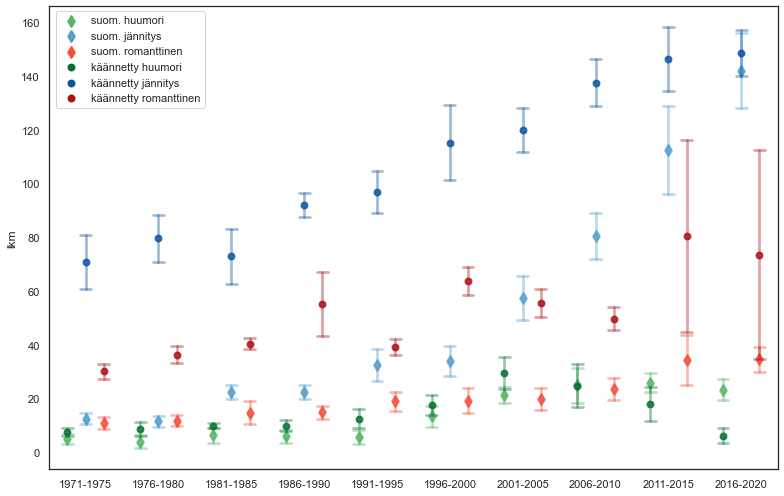

In [31]:
# plot I want to do in the end

fig,ax=plt.subplots(1, 1, figsize=(11,7))
combi_sub=fo_novel_author[fo_novel_author["year"]<2021]
combi_sub_fi=fi_novel[fi_novel["year"]<2021]

sns.pointplot('period', 'novel', hue='genre', alpha=0.7,
    data=combi_sub_fi, dodge=0.5, join=False, ci='sd', markers="d",palette=my_palette_2,ax=ax, capsize=0.15,scale = 1.1)


p=sns.pointplot('period2', 'novel', hue='genre', alpha=0.7,
    data=combi_sub, dodge=0.5, join=False, ci='sd', markers="o",palette=my_palette, ax=ax, capsize=0.15, scale = 0.9)

plt.setp(p.lines, alpha=.4) 
  

ax.get_legend().remove()
# add legend
handles, labels = ax.get_legend_handles_labels()
new_labels=["suom. huumori","suom. jännitys","suom. romanttinen","käännetty huumori", "käännetty jännitys", "käännetty romanttinen"]
fig.legend(handles[:6], new_labels, bbox_to_anchor=(0.27, 0.98))#, loc='upper left', ncol=1, bbox_to_anchor=(1, 0.98))
ax.set_xticklabels(labels=ax.get_xticklabels(), ha="center")

ax.set(xlabel='', ylabel='lkm')
fig.tight_layout()
plt.setp(p.collections, alpha=.8) 
#fig.savefig("../../output/figures/genre_5year_meansd.png")

In [32]:
# why is there such a SD in last romance publications
# a peak in 2015 and 2016
combi_sub[combi_sub["genre"]=="rakkaus"].tail(10)

,year,genre,novel,author,period,period2
122,2011,rakkaus,68,58,2011,2011-2015
125,2012,rakkaus,59,59,2011,2011-2015
128,2013,rakkaus,46,41,2011,2011-2015
131,2014,rakkaus,82,70,2011,2011-2015
134,2015,rakkaus,148,102,2011,2011-2015
137,2016,rakkaus,144,101,2016,2016-2020
140,2017,rakkaus,83,63,2016,2016-2020
143,2018,rakkaus,61,45,2016,2016-2020
146,2019,rakkaus,34,32,2016,2016-2020
149,2020,rakkaus,46,46,2016,2016-2020


In [33]:
genre_dict["rakkaus"]

['http://www.yso.fi/onto/koko/p12568',
 'http://www.yso.fi/onto/koko/p12857',
 'http://www.yso.fi/onto/koko/p50075',
 'http://www.yso.fi/onto/koko/p10465']

In [110]:
rom=df_fo[(df_fo["genre"]=="rakkaus")]
print(rom[rom["decade"]==2010].novel.nunique())
rom[rom["decade"]==2010#["novel"]

771


,genre,year,novel,lang,author,decade,period,nat,gender
2663,rakkaus,2011,http://www.btj.fi/at_1550294,http://lexvo.org/id/iso639-3/spa,http://www.btj.fi/actor_Llor%C3%A9ns%2C+Chufo,2010,2011,http://www.yso.fi/onto/koko/p13629,http://www.yso.fi/onto/kaunokki#male
2090,rakkaus,2011,http://www.btj.fi/at_1592683,http://lexvo.org/id/iso639-3/fra,http://www.btj.fi/actor_Malzieu%2C+Mathias,2010,2011,http://www.yso.fi/onto/koko/p3437,http://www.yso.fi/onto/kaunokki#male
1566,rakkaus,2011,http://www.btj.fi/at_1533146,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,2010,2011,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#female
236,rakkaus,2011,http://seco.tkk.fi/saha3/u064d4371-e7f6-41b6-8...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,2010,2011,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#female
1404,rakkaus,2011,http://www.btj.fi/at_1551337,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,2010,2011,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#female
...,...,...,...,...,...,...,...,...,...
889,rakkaus,2020,http://data.kirjasampo.fi/abstractWork_7216163,http://lexvo.org/id/iso639-3/eng,http://data.kirjasampo.fi/actor_DePalo%2C+Anna,2010,2016,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#female
1402,rakkaus,2020,http://data.kirjasampo.fi/abstractWork_7083282,http://lexvo.org/id/iso639-3/eng,http://data.kirjasampo.fi/actor_Kealey%2C+Imogen,2010,2016,http://www.yso.fi/onto/koko/p2224,NaN
1250,rakkaus,2020,http://data.kirjasampo.fi/abstractWork_4225741,http://lexvo.org/id/iso639-3/eng,http://seco.tkk.fi/saha3/ua4b23c8c-da38-4074-9...,2010,2016,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female
1027,rakkaus,2020,http://data.kirjasampo.fi/abstractWork_7108971,http://lexvo.org/id/iso639-3/eng,http://data.kirjasampo.fi/actor_Moriarty%2C+Liane,2010,2016,http://www.yso.fi/onto/koko/p9135,http://www.yso.fi/onto/kaunokki#female


In [35]:
# query labels:

name_query = """

SELECT ?novel ?title 
WHERE

{

VALUES ?novel  {  MY_VALUES }

?novel skos:prefLabel ?title . FILTER (LANG(?title)="fi")

}

"""

n=0
novel_list=[]
substring=""
for a_novel in rom[rom["decade"]==2010]["novel"].unique():
    
    if n < 200:
        teos = " <"+a_novel+">"
        substring +=teos
        n+=1
        
    else:
        print("a sublist")
        teos = " <"+a_novel+">"
        substring +=teos
        novel_list.append(substring)
        substring=""
        n=0

novel_list.append(substring)

a sublist
a sublist
a sublist


In [112]:
len(novel_list)
rom_novels=pd.DataFrame()
for nl in novel_list:
    sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
    q=name_query.replace("MY_VALUES", nl)
    sparql.setQuery(PREFIXES + q)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
    results = sparql.query().convert()
    temp = JSON2Pandas2(results)
    rom_novels=pd.concat([rom_novels, temp])

In [113]:

rom_novels=rom_novels.merge(df_fo[["year","novel"]], how="left")


In [114]:
rom_novels[rom_novels["year"].isin([2015,2016])].sample(50)
#rom_novels.sample(50)

,novel,title,year
345,http://data.kirjasampo.fi/abstractWork_4204395,Vaaraksi sydämelle ; Viettelyksen aallot ; Luv...,2015
380,http://data.kirjasampo.fi/abstractWork_4192179,Kevään tuulia,2015
638,http://data.kirjasampo.fi/abstractWork_4302282,Kadonnut Nora Robertsin maahan,2016
390,http://data.kirjasampo.fi/abstractWork_4197410,Yhden yön ihme ; Ihania houkutuksia,2015
438,http://data.kirjasampo.fi/abstractWork_4223615,Hänen lähellään,2015
418,http://data.kirjasampo.fi/abstractWork_4172533,Suvun suojeluksessa,2015
444,http://data.kirjasampo.fi/abstractWork_4254573,Salakuljettajakuningatar,2015
551,http://data.kirjasampo.fi/abstractWork_4089833,Lumoava totuus,2016
567,http://data.kirjasampo.fi/abstractWork_4187990,Suklaan maku,2016
443,http://data.kirjasampo.fi/abstractWork_4212711,Vauvatesti,2015


## Statistics about development per decade

In [39]:
# 
fo_sum=fo_novel_author.merge(fo_total, on="year", suffixes=["","_total"])
fi_sum=fi_novel.merge(fi_total, on="year", suffixes=["","_total"])
print(len(fi_sum))
fi_sum#.head()

150


,year,genre,novel,period,novel_total,author,gender
0,1971,huumori,4,1971,137,130,3
1,1971,jannitys,13,1971,137,130,3
2,1971,rakkaus,7,1971,137,130,3
3,1972,huumori,8,1971,144,129,3
4,1972,jannitys,11,1971,144,129,3
...,...,...,...,...,...,...,...
145,2019,jannitys,144,2016,769,682,3
146,2019,rakkaus,26,2016,769,682,3
147,2020,huumori,26,2016,840,748,3
148,2020,jannitys,166,2016,840,748,3


In [40]:
fi_total

,year,novel,author,gender
0,1971,137,130,3
1,1972,144,129,3
2,1973,148,142,3
3,1974,151,139,2
4,1975,131,117,2
5,1976,137,126,2
6,1977,147,132,2
7,1978,159,141,3
8,1979,162,149,2
9,1980,193,177,2


In [41]:
# genre novels per decade
fi_genre=df_fi.groupby(["decade"])[["novel"]].nunique().reset_index() # df_fi only contains genre
fo_genre=df_fo.groupby(["decade"])[["novel"]].nunique().reset_index()# df_fo only contains genre
fo_genre # genre sum per decade

,decade,novel
0,1970,1125
1,1980,1339
2,1990,1613
3,2000,1926
4,2010,2257
5,2020,312


In [42]:
fo_new=fo_genre.merge(dec_df, on="decade", suffixes=["_genre",""])
fi_new=fi_genre.merge(dec_df_fi, on="decade", suffixes=["_genre",""])
fi_new
#dfdf=fi_new.merge(fo_new, on=["decade","genre","period"], suffixes=["_fi",""])

,decade,novel_genre,novel
0,1970,275,1507
1,1980,423,1917
2,1990,589,2349
3,2000,1071,3785
4,2010,1827,6782


In [43]:
# add to this novel per genre
fi_genre_dec=df_fi.groupby(["decade","genre"])["novel"].nunique().reset_index()
fi_genre_dec
fo_genre_dec=df_fo.groupby(["decade","genre"])["novel"].nunique().reset_index()
fo_genre_dec

,decade,genre,novel
0,1970,huumori,81
1,1970,jannitys,753
2,1970,rakkaus,332
3,1980,huumori,100
4,1980,jannitys,820
5,1980,rakkaus,473
6,1990,huumori,152
7,1990,jannitys,1057
8,1990,rakkaus,515
9,2000,huumori,269


In [44]:
fi_decs=fi_new.merge(fi_genre_dec, on=["decade"], suffixes=["_total",""])
fo_decs=fo_new.merge(fo_genre_dec, on=["decade"], suffixes=["_total",""])

In [45]:
genre_table=fo_decs.merge(fi_decs, on=["decade","genre"], suffixes=["","_fi"])

In [46]:
genre_table["rel_fi"]=genre_table["novel_fi"]/genre_table["novel_total_fi"]
genre_table["rel"]=genre_table["novel"]/genre_table["novel_total"]
genre_table.columns

Index(['decade', 'novel_genre', 'novel_total', 'genre', 'novel',
       'novel_genre_fi', 'novel_total_fi', 'novel_fi', 'rel_fi', 'rel'],
      dtype='object')

In [47]:
print(genre_table[['decade', 'genre', 'novel', 'rel','novel_genre', 'novel_total', 'novel_fi', 'rel_fi', 
       'novel_genre_fi', 'novel_total_fi']].to_latex(index=False))
genre_table[['decade', 'genre', 'novel', 'rel','novel_genre', 'novel_total', 'novel_fi', 'rel_fi', 
       'novel_genre_fi', 'novel_total_fi']]

\begin{tabular}{rlrrrrrrrr}
\toprule
 decade &    genre &  novel &      rel &  novel\_genre &  novel\_total &  novel\_fi &   rel\_fi &  novel\_genre\_fi &  novel\_total\_fi \\
\midrule
   1970 &  huumori &     81 & 0.033048 &         1125 &         2451 &        45 & 0.029861 &             275 &            1507 \\
   1970 & jannitys &    753 & 0.307222 &         1125 &         2451 &       121 & 0.080292 &             275 &            1507 \\
   1970 &  rakkaus &    332 & 0.135455 &         1125 &         2451 &       113 & 0.074983 &             275 &            1507 \\
   1980 &  huumori &    100 & 0.036324 &         1339 &         2753 &        62 & 0.032342 &             423 &            1917 \\
   1980 & jannitys &    820 & 0.297857 &         1339 &         2753 &       225 & 0.117371 &             423 &            1917 \\
   1980 &  rakkaus &    473 & 0.171813 &         1339 &         2753 &       149 & 0.077726 &             423 &            1917 \\
   1990 &  huumori &    152 &

/tmp/ipykernel_23133/1185288668.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(genre_table[['decade', 'genre', 'novel', 'rel','novel_genre', 'novel_total', 'novel_fi', 'rel_fi',


,decade,genre,novel,rel,novel_genre,novel_total,novel_fi,rel_fi,novel_genre_fi,novel_total_fi
0,1970,huumori,81,0.033048,1125,2451,45,0.029861,275,1507
1,1970,jannitys,753,0.307222,1125,2451,121,0.080292,275,1507
2,1970,rakkaus,332,0.135455,1125,2451,113,0.074983,275,1507
3,1980,huumori,100,0.036324,1339,2753,62,0.032342,423,1917
4,1980,jannitys,820,0.297857,1339,2753,225,0.117371,423,1917
5,1980,rakkaus,473,0.171813,1339,2753,149,0.077726,423,1917
6,1990,huumori,152,0.049175,1613,3091,96,0.040868,589,2349
7,1990,jannitys,1057,0.341961,1613,3091,333,0.141762,589,2349
8,1990,rakkaus,515,0.166613,1613,3091,191,0.081311,589,2349
9,2000,huumori,269,0.059408,1926,4528,232,0.061295,1071,3785


In [48]:
genre_table2=genre_table
#genre_table2["FIxed"]= 
FIxed=genre_table2["novel_fi"].astype(str)+"("+round(genre_table2["rel_fi"],2).astype(str)+")"
FInnished=genre_table2["novel"].astype(str)+"("+round(genre_table2["rel"],2).astype(str)+")"
FI_total=genre_table2["novel_genre_fi"].astype(str)+" / "+genre_table2["novel_total_fi"].astype(str)
TR_total=genre_table2["novel_genre"].astype(str)+" / "+genre_table2["novel_total"].astype(str)

In [49]:
genre_table2["FI"]=FIxed
genre_table2["TR"]=FInnished
genre_table2["FI_total"]=FI_total
genre_table2["TR_total"]=TR_total

In [50]:
print(genre_table2[['decade', 'genre', 'FI', 'FI_total', 'TR', 'TR_total']].to_latex(index=False))

\begin{tabular}{rlllll}
\toprule
 decade &    genre &         FI &    FI\_total &         TR &    TR\_total \\
\midrule
   1970 &  huumori &   45(0.03) &  275 / 1507 &   81(0.03) & 1125 / 2451 \\
   1970 & jannitys &  121(0.08) &  275 / 1507 &  753(0.31) & 1125 / 2451 \\
   1970 &  rakkaus &  113(0.07) &  275 / 1507 &  332(0.14) & 1125 / 2451 \\
   1980 &  huumori &   62(0.03) &  423 / 1917 &  100(0.04) & 1339 / 2753 \\
   1980 & jannitys &  225(0.12) &  423 / 1917 &   820(0.3) & 1339 / 2753 \\
   1980 &  rakkaus &  149(0.08) &  423 / 1917 &  473(0.17) & 1339 / 2753 \\
   1990 &  huumori &   96(0.04) &  589 / 2349 &  152(0.05) & 1613 / 3091 \\
   1990 & jannitys &  333(0.14) &  589 / 2349 & 1057(0.34) & 1613 / 3091 \\
   1990 &  rakkaus &  191(0.08) &  589 / 2349 &  515(0.17) & 1613 / 3091 \\
   2000 &  huumori &  232(0.06) & 1071 / 3785 &  269(0.06) & 1926 / 4528 \\
   2000 & jannitys &  688(0.18) & 1071 / 3785 & 1288(0.28) & 1926 / 4528 \\
   2000 &  rakkaus &  217(0.06) & 1071 / 378

/tmp/ipykernel_23133/3949562254.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(genre_table2[['decade', 'genre', 'FI', 'FI_total', 'TR', 'TR_total']].to_latex(index=False))


# t-testi

In [51]:
# 1990-luvun KA VS 2010-luvun KA
fi_genre_year=df_fi.groupby(["year"])["novel"].nunique().reset_index()
fi_genre_year
fo_genre_year=df_fo.groupby(["year"])["novel"].nunique().reset_index()
fo_genre_year

,year,novel
0,1971,91
1,1972,107
2,1973,121
3,1974,107
4,1975,99
5,1976,113
6,1977,114
7,1978,134
8,1979,125
9,1980,115


In [52]:
fo_year=fo_total.merge(fo_genre_year, on="year", suffixes=["_total","_genre"])
fi_year=fi_total.merge(fi_genre_year, on="year", suffixes=["_total","_genre"])

In [53]:
fi_year["rel"]=fi_year["novel_genre"]/fi_year["novel_total"]
fi_year=add_decade(fi_year)
fi_year.head()

,year,novel_total,author,gender,novel_genre,rel,decade
0,1971,137,130,3,23,0.167883,1970
1,1972,144,129,3,30,0.208333,1970
2,1973,148,142,3,33,0.222973,1970
3,1974,151,139,2,29,0.192053,1970
4,1975,131,117,2,27,0.206107,1970


In [54]:
fo_year["rel"]=fo_year["novel_genre"]/fo_year["novel_total"]
fo_year=add_decade(fo_year)
fo_year.head()

,year,novel_total,author,gender,novel_genre,rel,decade
0,1971,193,170,3,91,0.471503,1970
1,1972,199,161,3,107,0.537688,1970
2,1973,240,199,3,121,0.504167,1970
3,1974,220,192,3,107,0.486364,1970
4,1975,238,205,3,99,0.415966,1970


In [55]:
import statsmodels.api as sm
from scipy import stats
import pandas
from scipy.stats import ttest_1samp,ttest_ind
# summary t-test, Finnish

# IT IS SIGNIFICANT ==> CHANGE

# t-test
testdf=fi_year
mean90 = testdf[testdf['decade'] == 1990]['rel']
mean2010 = testdf[testdf['decade'] == 2010]['rel']
print(np.mean(mean90), np.mean(mean2010))
print(ttest_ind(mean90, mean2010)  )


import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

0.2502866615012972 0.2713381949827903
Ttest_indResult(statistic=-1.8603370813229854, pvalue=0.07925720662227881)


/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable     N      Mean        SD        SE  95% Conf.  Interval
 0        90  10.0  0.250287  0.023718  0.007500   0.233320  0.267253
 1        10  10.0  0.271338  0.026795  0.008473   0.252170  0.290506
 2  combined  20.0  0.260812  0.026892  0.006013   0.248227  0.273398,
           Independent t-test  results
 0    Difference (90 - 10) =   -0.0211
 1      Degrees of freedom =   18.0000
 2                       t =   -1.8603
 3   Two side test p value =    0.0793
 4  Difference < 0 p value =    0.0396
 5  Difference > 0 p value =    0.9604
 6               Cohen's d =   -0.8320
 7               Hedge's g =   -0.7968
 8           Glass's delta =   -0.8876
 9             Pearson's r =    0.4016)

ShapiroResult(statistic=0.9749841094017029, pvalue=0.9328245520591736)
ShapiroResult(statistic=0.9815822839736938, pvalue=0.9730697274208069)
ShapiroResult(statistic=0.9281036257743835, pvalue=0.4295007884502411)


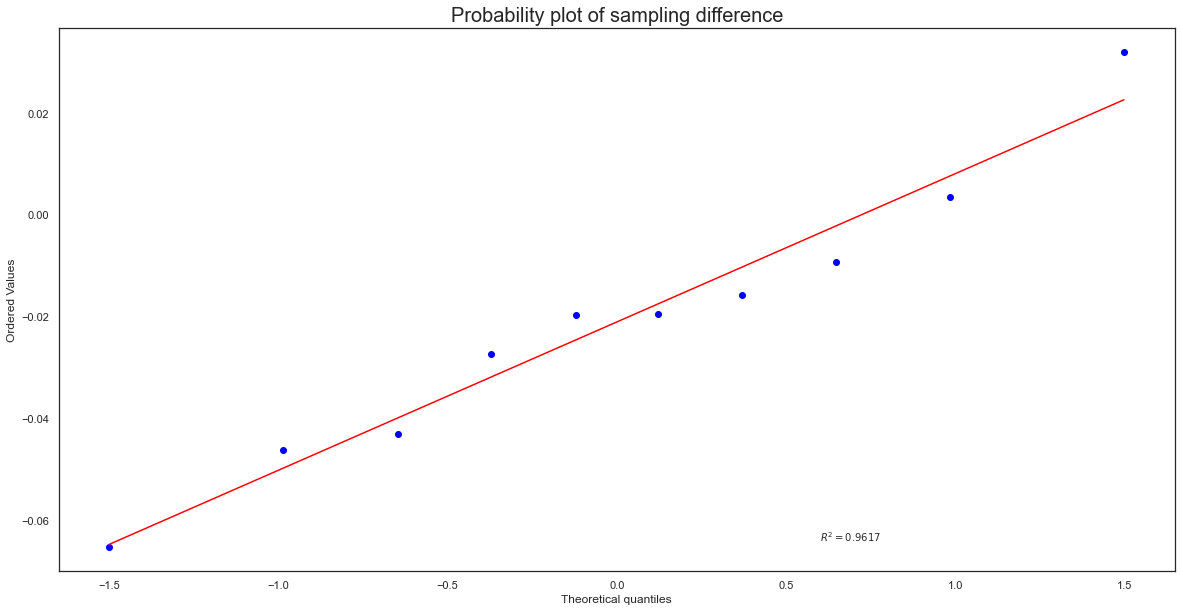

In [56]:
sampling_difference = mean90.values - \
                      mean2010.values

# not significant, normally distributed
print(stats.shapiro(sampling_difference))
print(stats.shapiro(mean90.values))
print(stats.shapiro(mean2010.values))

fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()



In [57]:
stats.levene(mean90.values,
             mean2010.values)

LeveneResult(statistic=0.09224169149708843, pvalue=0.7648291301505238)

In [58]:
testdf=fo_year
mean90 = testdf[testdf['decade'] == 1990]['rel']
mean2010 = testdf[testdf['decade'] == 2010]['rel']
print(np.mean(mean90), np.mean(mean2010))
print(ttest_ind(mean90, mean2010)  )


import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

0.522460136490871 0.48227345717173276
Ttest_indResult(statistic=1.6572588922566305, pvalue=0.1147933783583493)


/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable     N      Mean        SD        SE  95% Conf.  Interval
 0        90  10.0  0.522460  0.050046  0.015826   0.486660  0.558261
 1        10  10.0  0.482273  0.058099  0.018373   0.440712  0.523835
 2  combined  20.0  0.502367  0.056659  0.012669   0.475849  0.528884,
           Independent t-test  results
 0    Difference (90 - 10) =    0.0402
 1      Degrees of freedom =   18.0000
 2                       t =    1.6573
 3   Two side test p value =    0.1148
 4  Difference < 0 p value =    0.9426
 5  Difference > 0 p value =    0.0574
 6               Cohen's d =    0.7411
 7               Hedge's g =    0.7098
 8           Glass's delta =    0.8030
 9             Pearson's r =    0.3638)

In [59]:
sampling_difference = mean90.values - \
                      mean2010.values

# not significant, normally distributed
stats.shapiro(sampling_difference)

ShapiroResult(statistic=0.9793517589569092, pvalue=0.9616044759750366)

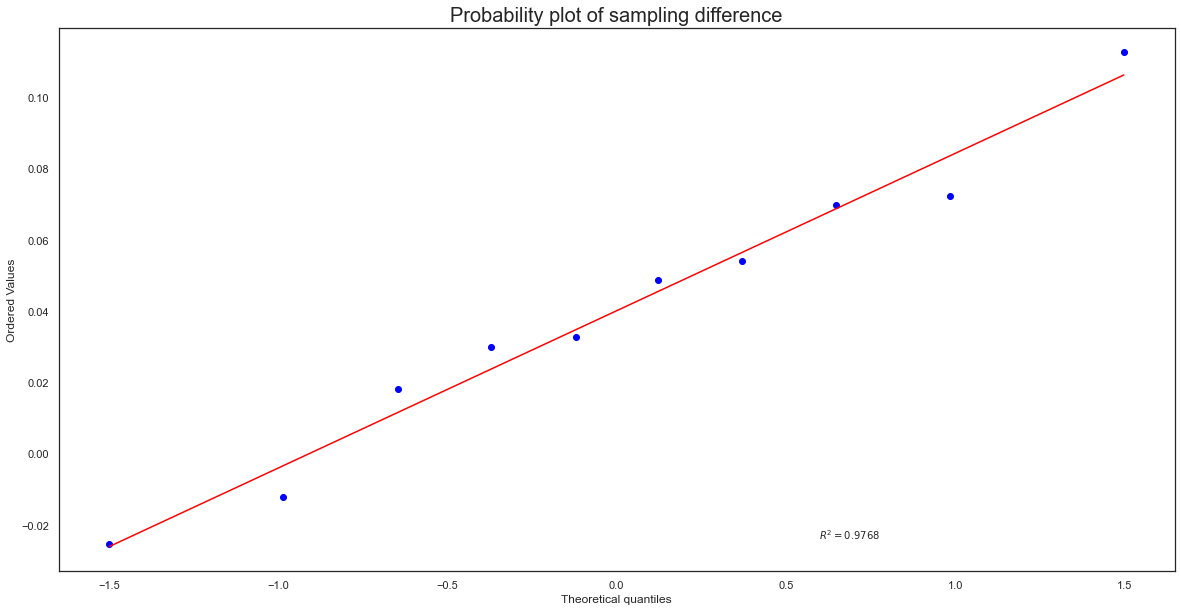

In [60]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()



In [61]:
stats.levene(mean90.values,
             mean2010.values,
             center= 'mean')

LeveneResult(statistic=0.0022974691488813212, pvalue=0.9622983263952111)

## stats pohj. jännitys

In [63]:
noir=df_fo.groupby(["genre","year","lang"])["novel"].nunique()
nordics=["http://lexvo.org/id/iso639-3/dan","http://lexvo.org/id/iso639-3/nor","http://lexvo.org/id/iso639-3/swe","http://lexvo.org/id/iso639-3/isl"]
nordic_crime_year=df_fo[(df_fo["genre"]=="jannitys")& (df_fo["lang"].isin(nordics))].groupby(["year"])["novel"].nunique().reset_index()
total_year_crime=df_fo[(df_fo["genre"]=="jannitys")].groupby(["year"])["novel"].nunique().reset_index()
df_crime=nordic_crime_year.merge(total_year_crime, on="year", suffixes=["_nordic",""])
df_crime["rel"]=df_crime["novel_nordic"]/df_crime["novel"]
df_crime=add_decade(df_crime)

In [64]:
testdf=df_crime
mean90 = testdf[testdf['decade'] == 1990]['rel']
mean2010 = testdf[testdf['decade'] == 2010]['rel']
print(np.mean(mean90), np.mean(mean2010))
print(ttest_ind(mean90, mean2010)  )


import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

0.08391016281675659 0.33257808260098065
Ttest_indResult(statistic=-9.88532432696308, pvalue=1.0662423056479072e-08)


/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable     N      Mean        SD        SE  95% Conf.  Interval
 0        90  10.0  0.083910  0.020846  0.006592   0.068998  0.098823
 1        10  10.0  0.332578  0.076768  0.024276   0.277662  0.387495
 2  combined  20.0  0.208244  0.138816  0.031040   0.143276  0.273212,
           Independent t-test  results
 0    Difference (90 - 10) =   -0.2487
 1      Degrees of freedom =   18.0000
 2                       t =   -9.8853
 3   Two side test p value =    0.0000
 4  Difference < 0 p value =    0.0000
 5  Difference > 0 p value =    1.0000
 6               Cohen's d =   -4.4209
 7               Hedge's g =   -4.2341
 8           Glass's delta =  -11.9288
 9             Pearson's r =    0.9189)

In [65]:
sampling_difference = mean90.values - \
                      mean2010.values

# not significant, normally distributed
stats.shapiro(sampling_difference)

ShapiroResult(statistic=0.9645264148712158, pvalue=0.8359848856925964)

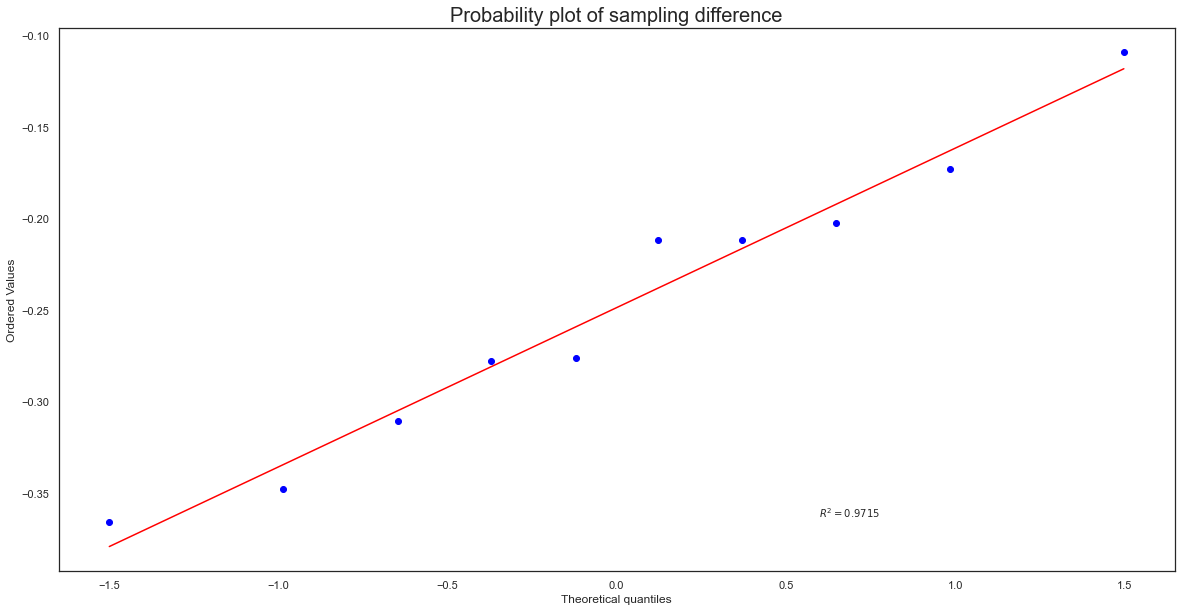

In [66]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [117]:
stats.levene(mean90.values,
             mean2010.values
            )

LeveneResult(statistic=11.971396827545107, pvalue=0.0027942592843158602)

In [ ]:
# do welch's?? or remove?

# plotting more plotting

In [68]:
# add authors to df_fi
df_fi=df_fi[df_fi["decade"]!=2020]
print(len(novel_df_fi), len(df_fi), df_fi.nunique())
df_fi2=novel_df_fi.merge(df_fi, on=["novel","year","decade"], how="left")
df_fi2.nunique()

16738 4340 genre        3
year        50
novel     4174
decade       5
period      10
dtype: int64


year         50
novel     16316
author     5380
gender        3
decade        5
genre         3
period       10
dtype: int64

In [69]:
# add authors to df_fo
df_fo=df_fo[df_fo["decade"]!=2020]
print(len(novel_df), len(df_fo), df_fo.nunique())
df_fo2=novel_df.merge(df_fo, on=["novel","year","decade","author"], how="left")
df_fo2.nunique()

18156 9042 genre        3
year        50
novel     8207
lang        39
author    2895
decade       5
period      10
nat         77
gender       2
dtype: int64


year           50
novel       17317
author       6025
gender_x        3
decade          5
genre           3
lang           39
period         10
nat            77
gender_y        2
dtype: int64

In [70]:
df_fo2.head()

,year,novel,author,gender_x,decade,genre,lang,period,nat,gender_y
0,2014,http://data.kirjasampo.fi/abstractWork_4075992,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#female,2010,NaN,NaN,NaN,NaN,NaN
1,2013,http://www.btj.fi/at_1940412,http://seco.tkk.fi/saha3/u64eb3370-2fde-4c01-a...,http://www.yso.fi/onto/kaunokki#male,2010,NaN,NaN,NaN,NaN,NaN
2,2004,http://www.yso.fi/onto/kaunokki#ateos_10798,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male,2000,NaN,NaN,NaN,NaN,NaN
3,2000,http://www.yso.fi/onto/kaunokki#ateos_10504,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male,1990,jannitys,http://lexvo.org/id/iso639-3/eng,1996.0,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male
4,2008,http://www.yso.fi/onto/kaunokki#ateos_5043,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male,2000,jannitys,http://lexvo.org/id/iso639-3/eng,2006.0,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male


In [71]:
print(len(df_fi2),len(df_fi2[["novel","year","genre"]].drop_duplicates()),len(df_fi2[["novel","year"]].drop_duplicates()))#["author"].isna().unique()

16888 16511 16363


In [72]:
df_fo2=add_decade(df_fo2)
fo_genre_gender_dec=df_fo2.groupby(["decade","genre","gender_x"])["novel"].nunique().reset_index()

fo_gender_dec=df_fo2.groupby(["decade","gender_x"])["novel"].nunique().reset_index()
fo_gender_dec

fo_genre_dec=df_fo2.groupby(["decade","genre"])["novel"].nunique().reset_index()

fo_dec=df_fo2.groupby(["decade"])["novel"].nunique().reset_index()
fo_gender_dec

,decade,gender_x,novel
0,1970,http://www.yso.fi/onto/kaunokki#female,798
1,1970,http://www.yso.fi/onto/kaunokki#male,1549
2,1970,unk,121
3,1980,http://www.yso.fi/onto/kaunokki#female,1062
4,1980,http://www.yso.fi/onto/kaunokki#male,1610
5,1980,unk,94
6,1990,http://www.yso.fi/onto/kaunokki#female,1343
7,1990,http://www.yso.fi/onto/kaunokki#male,1726
8,1990,unk,77
9,2000,http://www.yso.fi/onto/kaunokki#female,2206


In [73]:
df_fi2=add_decade(df_fi2)
fi_genre_gender_dec=df_fi2.groupby(["decade","genre","gender"])["novel"].nunique().reset_index()

fi_gender_dec=df_fi2.groupby(["decade","gender"])["novel"].nunique().reset_index()
fi_gender_dec

fi_genre_dec=df_fi2.groupby(["decade","genre"])["novel"].nunique().reset_index()

fi_dec=df_fi2.groupby(["decade"])["novel"].nunique().reset_index()
fi_genre_gender_dec

,decade,genre,gender,novel
0,1970,huumori,http://www.yso.fi/onto/kaunokki#female,5
1,1970,huumori,http://www.yso.fi/onto/kaunokki#male,40
2,1970,jannitys,http://www.yso.fi/onto/kaunokki#female,25
3,1970,jannitys,http://www.yso.fi/onto/kaunokki#male,92
4,1970,jannitys,unk,3
5,1970,rakkaus,http://www.yso.fi/onto/kaunokki#female,95
6,1970,rakkaus,http://www.yso.fi/onto/kaunokki#male,17
7,1980,huumori,http://www.yso.fi/onto/kaunokki#female,3
8,1980,huumori,http://www.yso.fi/onto/kaunokki#male,56
9,1980,huumori,unk,1


In [74]:
# get gender per genre
all_fo=fo_genre_gender_dec.merge(fo_genre_dec, on=["decade","genre"], suffixes=["_gender","_genre"])
all_fo.merge(fo_gender_dec).merge(fo_dec, on="decade",suffixes=["_gender","_total"])

/tmp/ipykernel_23133/3318656003.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'novel_gender'} in the result is deprecated and will raise a MergeError in a future version.
  all_fo.merge(fo_gender_dec).merge(fo_dec, on="decade",suffixes=["_gender","_total"])


,decade,genre,gender_x,novel_gender,novel_genre,novel_gender,novel_total
0,1970,huumori,http://www.yso.fi/onto/kaunokki#female,3,81,798,2451
1,1970,jannitys,http://www.yso.fi/onto/kaunokki#female,142,753,798,2451
2,1970,rakkaus,http://www.yso.fi/onto/kaunokki#female,206,332,798,2451
3,1970,huumori,http://www.yso.fi/onto/kaunokki#male,76,81,1549,2451
4,1970,jannitys,http://www.yso.fi/onto/kaunokki#male,555,753,1549,2451
5,1970,rakkaus,http://www.yso.fi/onto/kaunokki#male,113,332,1549,2451
6,1970,huumori,unk,3,81,121,2451
7,1970,jannitys,unk,68,753,121,2451
8,1970,rakkaus,unk,14,332,121,2451
9,1980,huumori,http://www.yso.fi/onto/kaunokki#female,10,100,1062,2753


In [75]:
all_fi=fi_genre_gender_dec.merge(fi_genre_dec, on=["decade","genre"], suffixes=["_genregender","_genre"]).merge(fi_dec).merge(fi_gender_dec, on=["decade","gender"], suffixes=["_total","_gender"])

In [76]:
#print(6*5)
all_fi[all_fi["gender"]!="unk"]

,decade,genre,gender,novel_genregender,novel_genre,novel_total,novel_gender
0,1970,huumori,http://www.yso.fi/onto/kaunokki#female,5,45,1507,636
1,1970,jannitys,http://www.yso.fi/onto/kaunokki#female,25,119,1507,636
2,1970,rakkaus,http://www.yso.fi/onto/kaunokki#female,95,112,1507,636
3,1970,huumori,http://www.yso.fi/onto/kaunokki#male,40,45,1507,865
4,1970,jannitys,http://www.yso.fi/onto/kaunokki#male,92,119,1507,865
5,1970,rakkaus,http://www.yso.fi/onto/kaunokki#male,17,112,1507,865
7,1980,huumori,http://www.yso.fi/onto/kaunokki#female,3,60,1917,884
8,1980,jannitys,http://www.yso.fi/onto/kaunokki#female,50,220,1917,884
9,1980,rakkaus,http://www.yso.fi/onto/kaunokki#female,114,145,1917,884
10,1980,huumori,http://www.yso.fi/onto/kaunokki#male,56,60,1917,1014


In [77]:

#all_fi.to_csv("././data/all_fi.csv",sep="/t")
#all_fo.to_csv("././data/all_fo.csv",sep="/t")


In [78]:
#df_fo["lang"]
df_fo[df_fo["genre"]=="huumori"].head(20)

,genre,year,novel,lang,author,decade,period,nat,gender
266,huumori,1971,http://seco.tkk.fi/saha3/u8746e373-711a-4a57-a...,http://lexvo.org/id/iso639-3/eng,http://seco.tkk.fi/saha3/uc16cf17f-d8be-4784-a...,1970,1971,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#female
97,huumori,1971,http://www.yso.fi/onto/kaunokki#ateos_5212,http://lexvo.org/id/iso639-3/rus,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p8327,http://www.yso.fi/onto/kaunokki#male
162,huumori,1971,http://www.yso.fi/onto/kaunokki#ateos_2960,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male
679,huumori,1971,http://www.yso.fi/onto/kaunokki#ateos_1864,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p3437,http://www.yso.fi/onto/kaunokki#male
18,huumori,1971,http://www.yso.fi/onto/kaunokki#ateos_12790,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p16897,NaN
725,huumori,1971,http://www.yso.fi/onto/kaunokki#ateos_815,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p8327,http://www.yso.fi/onto/kaunokki#male
748,huumori,1971,http://www.yso.fi/onto/kaunokki#ateos_9044,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male
158,huumori,1972,http://www.yso.fi/onto/kaunokki#ateos_6349,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male
666,huumori,1972,http://www.yso.fi/onto/kaunokki#ateos_1411,http://lexvo.org/id/iso639-3/rus,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p8327,http://www.yso.fi/onto/kaunokki#male
655,huumori,1972,http://www.yso.fi/onto/kaunokki#ateos_11574,http://lexvo.org/id/iso639-3/ita,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p12201,http://www.yso.fi/onto/kaunokki#male


In [79]:
# 4-plot

#df_fo

genre_info =pd.DataFrame()
for a_genre in ["jannitys","rakkaus","huumori"]:
    # gender per year
    temp=df_fo[df_fo["genre"]==a_genre]
    yearly_count=temp.groupby(["year","genre"])[["novel","author"]].nunique().reset_index()
    gender_count=temp.groupby(["year","genre","gender"])[["novel","author"]].nunique().reset_index()
    #lang_count=temp.groupby(["year","genre","gender"])[["lang"]].nunique().reset_index()
    #nat_count=temp.groupby(["year","genre","gender"])[["nat"]].nunique().reset_index()
    lang_count=temp.groupby(["year","genre"])[["lang"]].nunique().reset_index()
    nat_count=temp.groupby(["year","genre"])[["nat"]].nunique().reset_index()
    eng_share=df_fo[df_fo["lang"].isin(["http://lexvo.org/id/iso639-3/eng"])].groupby(["year","genre"])["novel"].nunique()
    nordic_share=df_fo[df_fo["lang"].isin(["http://lexvo.org/id/iso639-3/dan","http://lexvo.org/id/iso639-3/nor","http://lexvo.org/id/iso639-3/swe","http://lexvo.org/id/iso639-3/isl"])].groupby(["year","genre"])["novel"].nunique()
    new=yearly_count.merge(gender_count, on=["year","genre"],suffixes=["","_gender"])
    new=new.merge(lang_count,on=["year","genre"],suffixes=["","_lang"], how="left")
    new=new.merge(nat_count,on=["year","genre"],suffixes=["","_nat"], how="left")
    new=new.merge(eng_share,on=["year","genre"],suffixes=["","_eng"], how="left")
    new=new.merge(nordic_share,on=["year","genre"],suffixes=["","_nordic"], how="left")

    genre_info=pd.concat([genre_info, new])
    
genre_info.sort_values(by="year").head(15)

,year,genre,novel,author,gender,novel_gender,author_gender,lang,nat,novel_eng,novel_nordic
0,1971,jannitys,61,49,http://www.yso.fi/onto/kaunokki#female,8,6,5,9,42,8.0
1,1971,jannitys,61,49,http://www.yso.fi/onto/kaunokki#male,50,40,5,9,42,8.0
1,1971,huumori,7,7,http://www.yso.fi/onto/kaunokki#male,5,5,4,5,4,1.0
0,1971,huumori,7,7,http://www.yso.fi/onto/kaunokki#female,1,1,4,5,4,1.0
0,1971,rakkaus,30,30,http://www.yso.fi/onto/kaunokki#female,18,18,4,6,17,2.0
1,1971,rakkaus,30,30,http://www.yso.fi/onto/kaunokki#male,11,11,4,6,17,2.0
2,1972,jannitys,72,55,http://www.yso.fi/onto/kaunokki#female,14,11,6,10,49,17.0
3,1972,jannitys,72,55,http://www.yso.fi/onto/kaunokki#male,50,39,6,10,49,17.0
2,1972,huumori,10,10,http://www.yso.fi/onto/kaunokki#male,10,10,3,4,8,NaN
2,1972,rakkaus,30,23,http://www.yso.fi/onto/kaunokki#female,14,9,5,9,20,1.0


In [80]:
genre_info_fi =pd.DataFrame()
for a_genre in ["jannitys","rakkaus","huumori"]:
    # gender per year
    temp=df_fi2[df_fi2["genre"]==a_genre]
    yearly_count=temp.groupby(["year","genre"])[["novel","author"]].nunique().reset_index()
    gender_count=temp.groupby(["year","genre","gender"])[["novel","author"]].nunique().reset_index()
    
    new=yearly_count.merge(gender_count, on=["year","genre"],suffixes=["","_gender"])
    #new=new.merge(lang_count,on=["year","genre"],suffixes=["","_lang"], how="left")
    #new=new.merge(nat_count,on=["year","genre"],suffixes=["","_nat"], how="left")
    #new=new.merge(eng_share,on=["year","genre"],suffixes=["","_eng"], how="left")
    #new=new.merge(nordic_share,on=["year","genre"],suffixes=["","_nordic"], how="left")

    genre_info_fi=pd.concat([genre_info_fi, new])
    
genre_info_fi.sort_values(by="year").head(15)

,year,genre,novel,author,gender,novel_gender,author_gender
0,1971,jannitys,13,13,http://www.yso.fi/onto/kaunokki#female,4,4
0,1971,huumori,4,4,http://www.yso.fi/onto/kaunokki#female,2,2
1,1971,huumori,4,4,http://www.yso.fi/onto/kaunokki#male,2,2
0,1971,rakkaus,7,7,http://www.yso.fi/onto/kaunokki#female,7,7
1,1971,jannitys,13,13,http://www.yso.fi/onto/kaunokki#male,10,9
4,1972,jannitys,11,10,unk,1,1
2,1972,huumori,8,8,http://www.yso.fi/onto/kaunokki#male,8,8
2,1972,jannitys,11,10,http://www.yso.fi/onto/kaunokki#female,2,2
1,1972,rakkaus,11,10,http://www.yso.fi/onto/kaunokki#female,8,7
2,1972,rakkaus,11,10,http://www.yso.fi/onto/kaunokki#male,3,3


In [81]:
genre_info["eng_share"]=genre_info["novel_eng"]/genre_info["novel"]
genre_info["nordic_share"]=genre_info["novel_nordic"]/genre_info["novel"]

In [82]:
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

genre_info=add_period(genre_info)

In [83]:
genre_info_fi=add_period(genre_info_fi)

In [84]:
genre_info.head()

,year,genre,novel,author,gender,novel_gender,author_gender,lang,nat,novel_eng,novel_nordic,eng_share,nordic_share,period
0,1971,jannitys,61,49,http://www.yso.fi/onto/kaunokki#female,8,6,5,9,42,8.0,0.688525,0.131148,1971
1,1971,jannitys,61,49,http://www.yso.fi/onto/kaunokki#male,50,40,5,9,42,8.0,0.688525,0.131148,1971
2,1972,jannitys,72,55,http://www.yso.fi/onto/kaunokki#female,14,11,6,10,49,17.0,0.680556,0.236111,1971
3,1972,jannitys,72,55,http://www.yso.fi/onto/kaunokki#male,50,39,6,10,49,17.0,0.680556,0.236111,1971
4,1973,jannitys,86,63,http://www.yso.fi/onto/kaunokki#female,17,10,6,12,64,15.0,0.744186,0.174419,1971


In [85]:
#len(year_df)

In [86]:
# add gender_ratio
gender_rel=[]
for a_year in genre_info.year.unique():
    year_df_all=genre_info[genre_info["year"]==a_year]
    # get total count and male count
    for a_genre in ["jannitys","rakkaus","huumori"]:
        year_df=year_df_all[year_df_all["genre"]==a_genre]
        if len(year_df)> 0:
            total= year_df["novel"].iloc[0]
            if "http://www.yso.fi/onto/kaunokki#male" in year_df.gender.values :
                male = year_df[year_df["gender"]=="http://www.yso.fi/onto/kaunokki#male"]["novel_gender"].iloc[0]
            else:
                male = 0
            rel=male/total
            gender_rel.append({"year":a_year, "rel":rel, "genre":a_genre})
        else:
            print(whoops, a_year, a_genre)
            gender_rel.append({"year":a_year, "rel":0, "genre":a_genre})

In [87]:
genre_info=genre_info.merge(pd.DataFrame(gender_rel))
# df_fo2[df_fo2["lang"].isin(["http://lexvo.org/id/iso639-3/dan","http://lexvo.org/id/iso639-3/nor","http://lexvo.org/id/iso639-3/swe","http://lexvo.org/id/iso639-3/isl"])].groupby(["period","genre","gender"])["novel"].nunique()

In [88]:
gender_rel_fi=[]
for a_year in genre_info_fi.year.unique():
    year_df_all=genre_info_fi[genre_info_fi["year"]==a_year]
    # get total count and male count
    for a_genre in ["jannitys","rakkaus","huumori"]:
        year_df=year_df_all[year_df_all["genre"]==a_genre]
        if len(year_df)> 0:
            total= year_df["novel"].iloc[0]
            if "http://www.yso.fi/onto/kaunokki#male" in year_df.gender.values :
                male = year_df[year_df["gender"]=="http://www.yso.fi/onto/kaunokki#male"]["novel_gender"].iloc[0]
            else:
                male = 0
            rel=male/total
            gender_rel_fi.append({"year":a_year, "rel":rel, "genre":a_genre})
        else:
            print(whoops, a_year, a_genre)
            gender_rel_fi.append({"year":a_year, "rel":0, "genre":a_genre})

In [89]:
genre_info_fi=genre_info_fi.merge(pd.DataFrame(gender_rel_fi))


In [90]:
genre_info[genre_info["genre"]=="huumori"]

,year,genre,novel,author,gender,novel_gender,author_gender,lang,nat,novel_eng,novel_nordic,eng_share,nordic_share,period,rel
200,1971,huumori,7,7,http://www.yso.fi/onto/kaunokki#female,1,1,4,5,4,1.0,0.571429,0.142857,1971,0.714286
201,1971,huumori,7,7,http://www.yso.fi/onto/kaunokki#male,5,5,4,5,4,1.0,0.571429,0.142857,1971,0.714286
202,1972,huumori,10,10,http://www.yso.fi/onto/kaunokki#male,10,10,3,4,8,NaN,0.800000,NaN,1971,1.000000
203,1973,huumori,5,5,http://www.yso.fi/onto/kaunokki#male,5,5,2,3,3,2.0,0.600000,0.400000,1971,1.000000
204,1974,huumori,8,8,http://www.yso.fi/onto/kaunokki#male,8,8,4,4,5,2.0,0.625000,0.250000,1971,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2017,huumori,4,4,http://www.yso.fi/onto/kaunokki#male,4,4,3,4,2,1.0,0.500000,0.250000,2016,1.000000
280,2018,huumori,3,3,http://www.yso.fi/onto/kaunokki#male,3,3,1,2,3,NaN,1.000000,NaN,2016,1.000000
281,2019,huumori,7,7,http://www.yso.fi/onto/kaunokki#male,7,7,6,7,3,1.0,0.428571,0.142857,2016,1.000000
282,2020,huumori,6,6,http://www.yso.fi/onto/kaunokki#female,1,1,4,5,3,1.0,0.500000,0.166667,2016,0.833333


In [91]:
genre_info["rel"]=1-genre_info["rel"]
genre_info_fi["rel"]=1-genre_info_fi["rel"]

In [92]:
genre_info["nordic_share"].fillna(0,inplace=True)

In [93]:
genre_info["eng_share"].fillna(0,inplace=True)

In [94]:
# finnish against translations
genre_period_fi=genre_info_fi.groupby(["period","genre"])["novel"].nunique().reset_index()#/(genre_info_fi.groupby(["period","genre"])["novel"].nunique().values+genre_info.groupby(["period","genre"])["novel"].nunique().values)
genre_period_fo=genre_info.groupby(["period","genre"])["novel"].nunique().reset_index()#/(genre_info_fi.groupby(["period","genre"])["novel"].nunique().values+genre_info.groupby(["period","genre"])["novel"].nunique().values)
#genre_period_fo.merge_genre_perio
all_genre_info=genre_info_fi.merge(genre_info, on=["year","genre","period","gender"], suffixes=["_fi",""])
all_genre_info["fi_tr"]=all_genre_info["novel_fi"]/(all_genre_info["novel_fi"]+all_genre_info["novel"])

In [95]:
all_genre_info.head(10)

,year,genre,novel_fi,author_fi,gender,novel_gender_fi,author_gender_fi,period,rel_fi,novel,...,novel_gender,author_gender,lang,nat,novel_eng,novel_nordic,eng_share,nordic_share,rel,fi_tr
0,1971,jannitys,13,13,http://www.yso.fi/onto/kaunokki#female,4,4,1971,0.230769,61,...,8,6,5,9,42,8.0,0.688525,0.131148,0.180328,0.175676
1,1971,jannitys,13,13,http://www.yso.fi/onto/kaunokki#male,10,9,1971,0.230769,61,...,50,40,5,9,42,8.0,0.688525,0.131148,0.180328,0.175676
2,1972,jannitys,11,10,http://www.yso.fi/onto/kaunokki#female,2,2,1971,0.272727,72,...,14,11,6,10,49,17.0,0.680556,0.236111,0.305556,0.132530
3,1972,jannitys,11,10,http://www.yso.fi/onto/kaunokki#male,8,7,1971,0.272727,72,...,50,39,6,10,49,17.0,0.680556,0.236111,0.305556,0.132530
4,1973,jannitys,16,16,http://www.yso.fi/onto/kaunokki#female,4,4,1971,0.375000,86,...,17,10,6,12,64,15.0,0.744186,0.174419,0.267442,0.156863
5,1973,jannitys,16,16,http://www.yso.fi/onto/kaunokki#male,10,10,1971,0.375000,86,...,63,51,6,12,64,15.0,0.744186,0.174419,0.267442,0.156863
6,1974,jannitys,10,10,http://www.yso.fi/onto/kaunokki#female,2,2,1971,0.200000,77,...,20,14,8,15,58,9.0,0.753247,0.116883,0.285714,0.114943
7,1974,jannitys,10,10,http://www.yso.fi/onto/kaunokki#male,8,8,1971,0.200000,77,...,55,51,8,15,58,9.0,0.753247,0.116883,0.285714,0.114943
8,1975,jannitys,12,10,http://www.yso.fi/onto/kaunokki#female,2,2,1971,0.166667,59,...,13,8,7,12,43,9.0,0.728814,0.152542,0.254237,0.169014
9,1975,jannitys,12,10,http://www.yso.fi/onto/kaunokki#male,10,8,1971,0.166667,59,...,44,42,7,12,43,9.0,0.728814,0.152542,0.254237,0.169014


In [96]:
# simpson's diversity
def simpson_slice(df_slice):
  
  return df_slice**2 #.sum()

a_df=df_fo.drop_duplicates(["year","genre","novel"]).groupby(["lang","year","genre"])["novel"].nunique().reset_index()
#fo_total=df_fo.drop_duplicates(["year","genre","novel"]).groupby(["lang","year","genre"])["novel"].nunique().reset_index()
#[df_dec_genre_lang["genre"]==genre]
genre_year=df_fo.drop_duplicates(["year","genre","novel"]).groupby(["year","genre"])["novel"].nunique().reset_index()
genre_year

,year,genre,novel
0,1971,huumori,7
1,1971,jannitys,61
2,1971,rakkaus,30
3,1972,huumori,10
4,1972,jannitys,72
...,...,...,...
145,2019,jannitys,147
146,2019,rakkaus,34
147,2020,huumori,6
148,2020,jannitys,140


In [97]:
a_df=a_df.merge(genre_year, on=["year","genre"], suffixes=["","_total"])
a_df

,lang,year,genre,novel,novel_total
0,http://lexvo.org/id/iso639-3/afr,2013,jannitys,1,144
1,http://lexvo.org/id/iso639-3/dan,2013,jannitys,4,144
2,http://lexvo.org/id/iso639-3/deu,2013,jannitys,5,144
3,http://lexvo.org/id/iso639-3/eng,2013,jannitys,89,144
4,http://lexvo.org/id/iso639-3/est,2013,jannitys,1,144
...,...,...,...,...,...
964,http://lexvo.org/id/iso639-3/eng,2020,rakkaus,38,46
965,http://lexvo.org/id/iso639-3/est,2020,rakkaus,2,46
966,http://lexvo.org/id/iso639-3/fra,2020,rakkaus,1,46
967,http://lexvo.org/id/iso639-3/ita,2020,rakkaus,1,46


In [98]:
a_df["rel"]=a_df["novel"]/a_df["novel_total"]
simpson_df=a_df.groupby(["year","lang","genre"]).rel.agg(simpson_slice).reset_index(name="simpson")
simpson=simpson_df.groupby(["year","genre"]).simpson.sum().apply(lambda x: 1-x).reset_index()
simpson["s_1"]=simpson.groupby(["year","genre"]).simpson.sum().values
#simpson
#simpson_df
#simpson["period"]=pd.to_numeric(simpson["year"])
    
simpson=add_period(simpson)
simpson

,year,genre,simpson,s_1,period
0,1971,huumori,0.612245,0.612245,1971
1,1971,jannitys,0.486428,0.486428,1971
2,1971,rakkaus,0.580000,0.580000,1971
3,1972,huumori,0.340000,0.340000,1971
4,1972,jannitys,0.505401,0.505401,1971
...,...,...,...,...,...
145,2019,jannitys,0.678236,0.678236,2016
146,2019,rakkaus,0.359862,0.359862,2016
147,2020,huumori,0.666667,0.666667,2016
148,2020,jannitys,0.650612,0.650612,2016


In [99]:

# palette
pal_pub=sns.color_palette("Purples_r",5)
pal_nordic=sns.color_palette("Blues_r",5)
pal_fitr=sns.color_palette("coolwarm",10)
pal_lang=sns.color_palette("Oranges_r",5)
pal_nat=sns.color_palette("Greens_r",5)
pal_trfi=sns.color_palette("magma",10)
colormap=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_pub)}
colormap2=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_nordic)}
colormap_fitr=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_fitr[:5])}
colormap_trfi=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_trfi[2:8])}
colormap3=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_lang)}
colormap4=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_nat)}
pal_fitr


[(0.3383765114431373, 0.45281860883137254, 0.8793170768784313),
 (0.4570464785254902, 0.5940055499294118, 0.963029229690196),
 (0.5814861481882353, 0.7134505955294117, 0.9983143529411764),
 (0.7087196897176471, 0.8057213889294117, 0.9811168090470588),
 (0.8180564934117647, 0.8555896775450981, 0.9146376165490196),
 (0.9094595977529412, 0.8393864797647058, 0.8003313524235294),
 (0.9616447383764706, 0.7580291825411765, 0.6617823791647058),
 (0.963806056435294, 0.6341884145294118, 0.5137208491529413),
 (0.9182816725843137, 0.48417347218039214, 0.37779392507058823),
 (0.8301865219490197, 0.30473276355294115, 0.25489142806666665)]

In [100]:
genre_info.head()

,year,genre,novel,author,gender,novel_gender,author_gender,lang,nat,novel_eng,novel_nordic,eng_share,nordic_share,period,rel
0,1971,jannitys,61,49,http://www.yso.fi/onto/kaunokki#female,8,6,5,9,42,8.0,0.688525,0.131148,1971,0.180328
1,1971,jannitys,61,49,http://www.yso.fi/onto/kaunokki#male,50,40,5,9,42,8.0,0.688525,0.131148,1971,0.180328
2,1972,jannitys,72,55,http://www.yso.fi/onto/kaunokki#female,14,11,6,10,49,17.0,0.680556,0.236111,1971,0.305556
3,1972,jannitys,72,55,http://www.yso.fi/onto/kaunokki#male,50,39,6,10,49,17.0,0.680556,0.236111,1971,0.305556
4,1973,jannitys,86,63,http://www.yso.fi/onto/kaunokki#female,17,10,6,12,64,15.0,0.744186,0.174419,1971,0.267442


['jannitys', 'rakkaus', 'huumori']


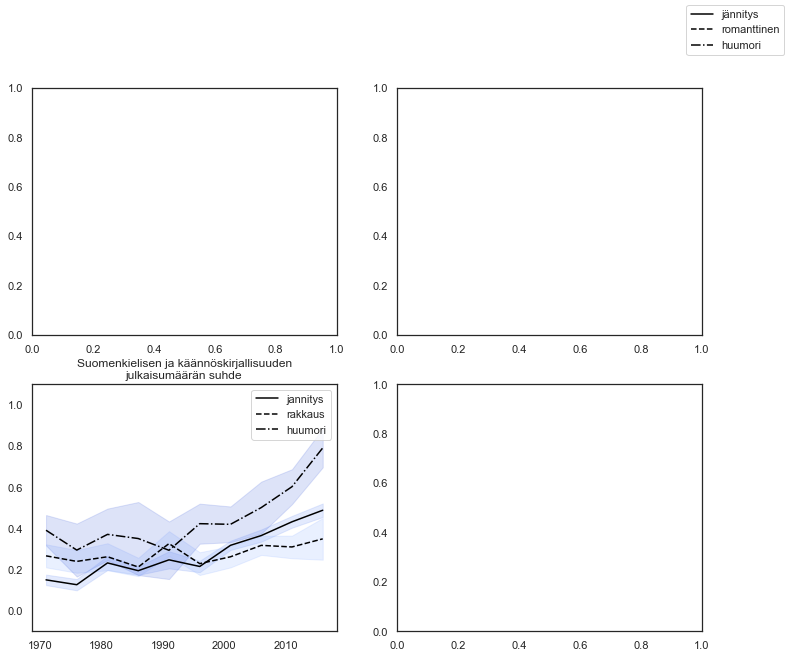

In [102]:
fig,ax=plt.subplots(2,2, figsize=(12,10))

line_style={"rakkaus":"--","jannitys":"-","huumori":"-."}
# suom -- käännös suhde
for genre in genre_info_fi.genre.unique():
    temp=all_genre_info[(all_genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    feature="fi_tr"
    mean_2=temp.groupby("period")[feature].mean().reset_index()  
    mean_shade=temp.groupby("period")[feature].mean()
    std_2=temp.groupby("period")[feature].std()#.reset_index()  
    temp_size=temp.groupby("period")["novel"].sum().reset_index()  
    temp_df=temp_size.merge(mean_2)
    years=list(mean_shade.index)
    max_size=temp_size["novel"].max()

    #print(len(temp_size),len(years), len(mean_2))
    #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
    p=sns.lineplot(x="period", y=feature,  ax=ax[1][0], data=temp_df,color="black", linestyle=line_style[genre], label=genre)#,linestyle=line_style[feature])
    ax[1][0].set(title='Suomenkielisen ja käännöskirjallisuuden\njulkaisumäärän suhde')
    #ax[1][0].legend([], frameon=False)
    ax[1][0].set(ylim=(-0.1, 1.1))#, xlim=(1969,20))
    ax[1][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_fitr[genre], alpha=0.2)
    ax[1][0].set(xlabel='', ylabel='')
#p.legend(bbox_to_anchor=(-1.05, 1), loc='upper left')
m,n=p.get_legend_handles_labels()
print(n)
n=["jännitys", "romanttinen","huumori"]
fig.legend(labels=n, handles=m)


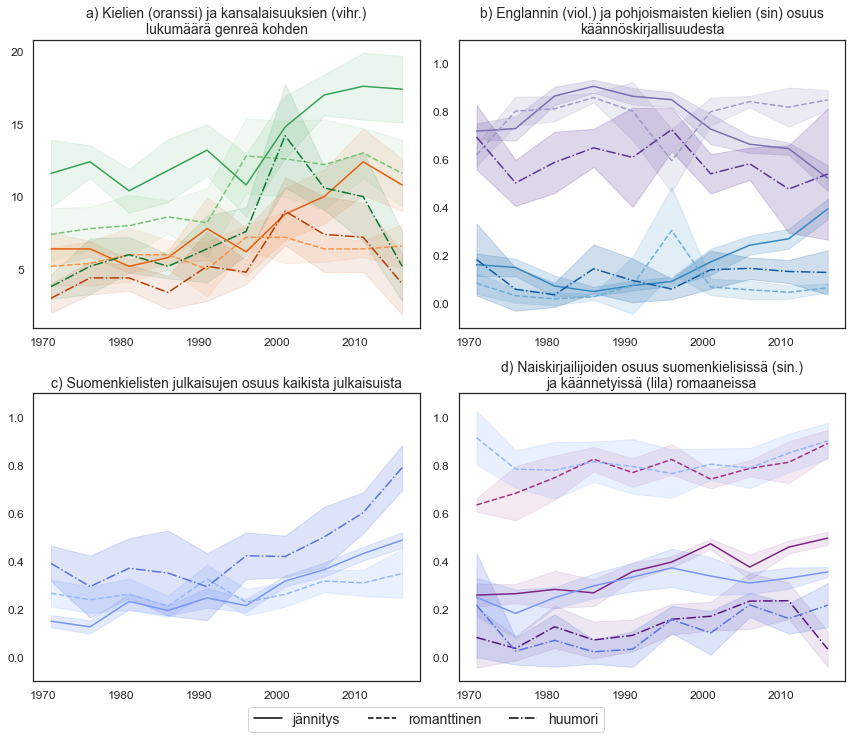

In [104]:
fig,ax=plt.subplots(2,2, figsize=(12,10))



SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


pal_nordic=sns.color_palette("Blues")
pal_eng=sns.color_palette("PuOr")
pal_s=sns.color_palette("Greens")
pal_genre={"jannitys":pal_nordic[4], "rakkaus":pal_eng[5],"huumori":pal_s[4]}
pal_genre2={"jannitys":pal_nordic[2], "rakkaus":pal_eng[4],"huumori":pal_s[2]}

pal_feat={"nordic_share":pal_nordic[2],"eng_share":pal_eng[5]}
line_style={"nat":"--","lang":"-"}
line_style={"rakkaus":"--","jannitys":"-","huumori":"-."}
line_lang={"eng_share":"-", "nordic_share":"-"}
markers={"nat":"d","lang":"o", "eng_share":"d","nordic_share":"s"}
for genre in genre_info.genre.unique():
    temp=genre_info[(genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    for feature in ["nat"]:
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][0], color=pal_genre[genre])
        
        sns.lineplot(x="period", y=feature,  ax=ax[0][0], data=temp_df,color=colormap4[genre],linestyle=line_style[genre])
       #ax[0][0].set(title='Kielien lukumäärä genreä kohden')
        ax[0][0].legend([], frameon=False)
        ax[0][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap4[genre], alpha=0.1)
        ax[0][0].set(xlabel='', ylabel='')
        
    for feature in ["lang"]:
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][0], color=pal_genre[genre])
        
        sns.lineplot(x="period", y=feature,  ax=ax[0][0], data=temp_df,color=colormap3[genre],linestyle=line_style[genre])
        ax[0][0].set(title='a) Kielien (oranssi) ja kansalaisuuksien (vihr.)\nlukumäärä genreä kohden')
        ax[0][0].legend([], frameon=False)
        ax[0][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap3[genre], alpha=0.1)
        ax[0][0].set(xlabel='', ylabel='')
        ax[0][0].locator_params(axis="y", integer=True, tight=False)
for genre in genre_info.genre.unique():
    temp=genre_info[(genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    #print()
    for feature in ["eng_share","nordic_share"]:
    #feature="eng_share"
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
        if feature =="eng_share":
            sns.lineplot(x="period", y=feature,  ax=ax[0][1], data=temp_df,color=colormap[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
            ax[0][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap[genre], alpha=0.2)
        else:
            sns.lineplot(x="period", y=feature,  ax=ax[0][1], data=temp_df,color=colormap2[genre], linestyle=line_style[genre])
            ax[0][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap2[genre], alpha=0.2)
        ax[0][1].set(title='b) Englannin (viol.) ja pohjoismaisten kielien (sin) osuus\nkäännöskirjallisuudesta')
        ax[0][1].legend([], frameon=False)
        ax[0][1].set(ylim=(-0.1, 1.1))#, xlim=(1969,2020))
        ax[0][1].set(xlabel='', ylabel='')
        
        
for genre in genre_info.genre.unique():
    temp=genre_info[(genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    #print()
    for feature in ["rel"]:
    #feature="eng_share"
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
        sns.lineplot(x="period", y=feature,  ax=ax[1][1], data=temp_df,color=colormap_trfi[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
        ax[1][1].set(title='Gender share')
        ax[1][1].legend([], frameon=False)
        ax[1][1].set(ylim=(-0.1, 1.1))
        ax[1][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_trfi[genre], alpha=0.1)
        ax[1][1].set(xlabel='', ylabel='')
        
# suom sukupuolijakauma
for genre in genre_info_fi.genre.unique():
    temp=genre_info_fi[(genre_info_fi["genre"]==genre)].drop_duplicates(["genre","year"])
    #print()
    for feature in ["rel"]:
    #feature="eng_share"
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
        sns.lineplot(x="period", y=feature,  ax=ax[1][1], data=temp_df,color=colormap_fitr[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
        ax[1][1].set(title='d) Naiskirjailijoiden osuus suomenkielisissä (sin.)\nja käännetyissä (lila) romaaneissa')
        ax[1][1].legend([], frameon=False)
        ax[1][1].set(ylim=(-0.1, 1.1))
        ax[1][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_fitr[genre], alpha=0.2)
        ax[1][1].set(xlabel='', ylabel='')
        
                
# suom -- käännös suhde
for genre in genre_info_fi.genre.unique():
    temp=all_genre_info[(all_genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    feature="fi_tr"
    mean_2=temp.groupby("period")[feature].mean().reset_index()  
    mean_shade=temp.groupby("period")[feature].mean()
    std_2=temp.groupby("period")[feature].std()#.reset_index()  
    temp_size=temp.groupby("period")["novel"].sum().reset_index()  
    temp_df=temp_size.merge(mean_2)
    years=list(mean_shade.index)
    max_size=temp_size["novel"].max()

    #print(len(temp_size),len(years), len(mean_2))
    #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
    sns.lineplot(x="period", y=feature,  ax=ax[1][0], data=temp_df,color=colormap_fitr[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
    ax[1][0].set(title='c) Suomenkielisten julkaisujen osuus kaikista julkaisuista')
    ax[1][0].legend([], frameon=False)
    ax[1][0].set(ylim=(-0.1, 1.1))#, xlim=(1969,20))
    ax[1][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_fitr[genre], alpha=0.2)
    ax[1][0].set(xlabel='', ylabel='')
#for an_ax in list(ax):
#    an_ax.set(xlabel='', ylabel='')

legend=fig.legend(labels=n, handles=m, loc="lower center", ncol=3,  bbox_to_anchor=(0.5, -0.035))
fig.tight_layout()
fig.savefig("../../output/genre_plots4_new.png",bbox_extra_artists=(legend,), bbox_inches='tight')